In [1]:
#pip install NRCLex

In [398]:
# Import required modules
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import requests
from LeXmo import LeXmo
from preprocessing import processing
import pickle
import os
from tqdm.notebook import tqdm
import statsmodels.formula.api as sm
from scipy.stats import t 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ellietupin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [224]:
# Import earning calls
tickers = ["AAPL","MMM"]

texts = []
list_ids = []
Ticker = []
number_texts_per_stock = []
for ticker in tickers:
    dir_path = "data/text/"+ticker+"/"
    list_ids1 = os.listdir(dir_path)
    ticker1 = os.path.basename(os.path.dirname(dir_path))
    ticker1 = ticker1.split()
    texts1 = []
    for s in list_ids1:
        with open(dir_path + s, encoding = 'ISO-8859-1') as f:
            t = f.read()
            texts1.append(t)
    texts = texts + texts1
    list_ids = list_ids + list_ids1 
    Ticker = Ticker + ticker1*len(list_ids1)
    number_texts_per_stock.append(len(list_ids1))
print(len(texts))
print(len(list_ids))
print(len(Ticker))
print(number_texts_per_stock)

132
132
132
[66, 66]


In [223]:
# Get dates
data_path = "data/ticker/id_to_date"
with open(data_path,"rb") as file :
    id_to_date = pickle.load(file)

13840
132


In [218]:
# Create dataframe with earning calls informations
df1 = pd.DataFrame(data={'id': list_ids})
df1['date']=list_ids
df1=df1.replace({'date': id_to_date})
df1['date'] = pd.to_datetime(df1['date'])
df1['quarter'] = df1['date'].dt.to_period('Q')
df1['ticker']= Ticker
df1=df1.replace({'ticker': id_to_date})
df1= df1.sort_values(['ticker','date'], ascending=True)
display(df1)

,id,date,quarter,ticker
55,5939,2006-01-19,2006Q1,AAPL
65,9249,2006-04-20,2006Q2,AAPL
1,13884,2006-07-19,2006Q3,AAPL
21,18756,2006-10-19,2006Q4,AAPL
37,24432,2007-01-17,2007Q1,AAPL
...,...,...,...,...
115,4421773,2021-04-27,2021Q2,MMM
128,4441710,2021-07-27,2021Q3,MMM
86,4462080,2021-10-26,2021Q4,MMM
123,4481561,2022-01-25,2022Q1,MMM


In [ ]:
## To do : keep same sumber of raws for each stock
## For the moment : only 2 stocks of same lenghth so ok!

# Import datas from yahoo finance

Import html tickers from data/ticker
dir_path = "data/ticker/"
list_tickers = os.listdir(dir_path)
list_tickers.remove('.DS_Store') # for mac
list_tickers.remove('id_to_date')
print(list_tickers)

Test with few stocks
list_tickers = ['AAPL']

In [368]:
# Get the month from which we import
# Q1 : from january (1) to march (3)
# Q2 : from april (4) to june (6)
# Q3 : from july (7) to septmber (9)
# Q4 : from october (10) to december (12)

quarter_start = df1['quarter'].iloc[0].quarter
month_start = quarter_start*2-1
quarter_end = df1['quarter'].iloc[-2].quarter # take the last quarter
month_end = quarter_end*3

if month_end in [3,12]:
    day_end = 31
else:
    day_end = 30

In [369]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

start = datetime.datetime(df1['date'].iloc[0].year,month_start,1)
end   = datetime.datetime(df1['date'].iloc[-1].year,month_end,day_end)

# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
list_tickers = list(set(Ticker))
for i in list_tickers:  
    
    # print the symbol which is being downloaded
    print( str(list_tickers.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['ticker']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
        
stock_final['date']=stock_final.index
stock_final['quarter'] = stock_final['date'].dt.to_period('Q')
stock_final['market_cap']=stock_final['Adj Close']*stock_final['Volume']
stock_final=stock_final.drop(columns=['Open', 'High','Low','Close','date','Adj Close','Volume'])
display(stock_final)

0 : AAPL,1 : MMM,

,ticker,quarter,market_cap
Date,,,
2006-01-03,AAPL,2006Q1,1.842587e+09
2006-01-04,AAPL,2006Q1,1.418465e+09
2006-01-05,AAPL,2006Q1,1.020771e+09
2006-01-06,AAPL,2006Q1,1.641332e+09
2006-01-09,AAPL,2006Q1,1.567640e+09
...,...,...,...
2022-03-24,MMM,2022Q1,2.991235e+08
2022-03-25,MMM,2022Q1,3.348204e+08
2022-03-28,MMM,2022Q1,3.965571e+08


In [370]:
stock_final = stock_final.groupby(['ticker','quarter']).sum()
stock_final['percent_change']=stock_final['market_cap'].pct_change()
display(stock_final)
Quarter = stock_final.index.get_level_values(1)

market_cap  percent_change
ticker quarter                              
AAPL   2006Q1   1.366339e+11             NaN
       2006Q2   1.053552e+11       -0.228924
       2006Q3   1.071530e+11        0.017065
       2006Q4   1.146667e+11        0.070121
       2007Q1   1.549110e+11        0.350968
...                      ...             ...
MMM    2021Q1   3.010345e+10        0.261134
       2021Q2   2.598981e+10       -0.136650
       2021Q3   2.849874e+10        0.096535
       2021Q4   2.508179e+10       -0.119898
       2022Q1   3.378054e+10        0.346815

[130 rows x 2 columns]

# Text analysis

In [257]:
# Preprocessing
n= len(texts)
texts = [processing(x) for x in texts]

In [261]:
#N=len(texts)

for i in tqdm(range(n)):
    # creating objects
    text=texts[i]
    emo = LeXmo.LeXmo(text)
    emo.pop('text', None)
    emo_array = np.array(list(emo.items()))
    score = emo_array[:,1]
    if i==0:
        con = score
    else :
        con = np.vstack((con, score))

  0%|          | 0/132 [00:00<?, ?it/s]

In [386]:
# Create dataframe
score = np.reshape(con, (n, 10))
column=['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise','trust']
df = pd.DataFrame(score, columns = column)
df[column]=df[column].astype(float)

#number_words = np.zeros(n)
#for i in range(n):
#    number_words[i] = len(texts[i])
#df['number_words']=number_words
df['id'] = list_ids
df['date']=list_ids
df=df.replace({'date': id_to_date})
df['date'] = pd.to_datetime(df['date'])
#df['quarter'] = Quarter
df['ticker']= Ticker
df= df.sort_values(by=['ticker','date'], ascending=True)
# Remove most recent text for each ticker
df=df.drop(df.groupby('ticker').tail(1).index, axis=0)
# Add quarters
df['quarter']=Quarter
df_final=df
display(df)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,id,date,ticker,quarter
55,0.011084,0.057153,0.005888,0.013162,0.028750,0.021822,0.089713,0.012816,0.013855,0.043644,5939,2006-01-19,AAPL,2006Q1
65,0.017539,0.052324,0.003215,0.016954,0.021923,0.030985,0.087109,0.015493,0.013739,0.041508,9249,2006-04-20,AAPL,2006Q2
1,0.013377,0.047722,0.002531,0.014823,0.016992,0.027838,0.087129,0.015546,0.008315,0.040492,13884,2006-07-19,AAPL,2006Q3
21,0.012616,0.058627,0.004824,0.012245,0.023377,0.023006,0.090167,0.014100,0.011503,0.047124,18756,2006-10-19,AAPL,2006Q4
37,0.011411,0.047147,0.003303,0.012913,0.015616,0.023724,0.076577,0.017117,0.009009,0.038739,24432,2007-01-17,AAPL,2007Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.005229,0.046351,0.003328,0.007606,0.017114,0.021155,0.080818,0.010221,0.009983,0.046351,4401158,2021-01-26,MMM,2021Q1
115,0.006844,0.033714,0.001521,0.006337,0.012421,0.023574,0.076553,0.010900,0.009379,0.042586,4421773,2021-04-27,MMM,2021Q2
128,0.009051,0.039416,0.003796,0.009635,0.014599,0.031825,0.068613,0.016058,0.011971,0.049927,4441710,2021-07-27,MMM,2021Q3
86,0.007950,0.046977,0.005541,0.014454,0.022163,0.031318,0.076849,0.017827,0.012045,0.047218,4462080,2021-10-26,MMM,2021Q4


In [387]:
df_change = df_final
column_change=['anger_change','anticipation_change','disgust_change','fear_change','joy_change','negative_change','positive_change','sadness_change','surprise_change','trust_change']
df_change[column] = df[column].pct_change()
#df_change.columns =column_change
df_change = df_change.drop(columns=['id','date'])
df_change = df_change.groupby(['ticker','quarter']).sum()
display(df_change)

anger  anticipation   disgust      fear       joy  \
ticker quarter                                                         
AAPL   2006Q1   0.000000      0.000000  0.000000  0.000000  0.000000   
       2006Q2   0.582322     -0.084491 -0.453944  0.288066 -0.237435   
       2006Q3  -0.237304     -0.087943 -0.212943 -0.125707 -0.224936   
       2006Q4  -0.056872      0.228504  0.906069 -0.173917  0.375739   
       2007Q1  -0.095478     -0.195813 -0.315200  0.054555 -0.331999   
...                  ...           ...       ...       ...       ...   
MMM    2021Q1  -0.304318      0.022034  0.207382 -0.156749 -0.101272   
       2021Q2   0.308780     -0.272652 -0.542966 -0.166865 -0.274247   
       2021Q3   0.322466      0.169145  1.495620  0.520409  0.175331   
       2021Q4  -0.121665      0.191815  0.459797  0.500186  0.518188   
       2022Q1  -0.580807     -0.062574 -0.398549 -0.390673 -0.140784   

                negative  positive   sadness  surprise     trust  
ticker quarter                                                    
AAPL   2006Q1   0.000000  0.000000  0.000000  0.000000  0.000000  
       2006Q2   0.419904 -0.029020  0.208837 -0.008411 -0.048932  
       2006Q3  -0.101567  0.000234  0.003445 -0.394755 -0.024493  
       2006Q4  -0.173592  0.034862 -0.092997  0.383335  0.163802  
       2007Q1   0.031217 -0.150725  0.213964 -0.216797 -0.177946  
...                  ...       ...       ...       ...       ...  
MMM    2021Q1  -0.210930 -0.067794 -0.296685  0.138388 -0.056183  
       2021Q2   0.114342 -0.052774  0.066413 -0.060541 -0.081244  
       2021Q3   0.349988 -0.103712  0.473264  0.276346  0.172393  
       2021Q4  -0.015933  0.120033  0.110138  0.006222 -0.054269  
       2022Q1  -0.331134  0.031463 -0.305661 -0.249045  0.038511  

[130 rows x 10 columns]

In [388]:
# Merge dataframes
df_change = pd.merge(stock_final, df_change, left_index=True, right_index=True)
# Drop first row
df_change=df_change.drop(df_change.groupby('ticker').head(1).index, axis=0)
display(df_change)

market_cap  percent_change     anger  anticipation  \
ticker quarter                                                         
AAPL   2006Q2   1.053552e+11       -0.228924  0.582322     -0.084491   
       2006Q3   1.071530e+11        0.017065 -0.237304     -0.087943   
       2006Q4   1.146667e+11        0.070121 -0.056872      0.228504   
       2007Q1   1.549110e+11        0.350968 -0.095478     -0.195813   
       2007Q2   1.834242e+11        0.184062  0.318669      0.037297   
...                      ...             ...       ...           ...   
MMM    2021Q1   3.010345e+10        0.261134 -0.304318      0.022034   
       2021Q2   2.598981e+10       -0.136650  0.308780     -0.272652   
       2021Q3   2.849874e+10        0.096535  0.322466      0.169145   
       2021Q4   2.508179e+10       -0.119898 -0.121665      0.191815   
       2022Q1   3.378054e+10        0.346815 -0.580807     -0.062574   

                 disgust      fear       joy  negative  positive   sadness  \
ticker quarter                                                               
AAPL   2006Q2  -0.453944  0.288066 -0.237435  0.419904 -0.029020  0.208837   
       2006Q3  -0.212943 -0.125707 -0.224936 -0.101567  0.000234  0.003445   
       2006Q4   0.906069 -0.173917  0.375739 -0.173592  0.034862 -0.092997   
       2007Q1  -0.315200  0.054555 -0.331999  0.031217 -0.150725  0.213964   
       2007Q2   0.760042  0.006426 -0.189664  0.311841 -0.026394  0.038952   
...                  ...       ...       ...       ...       ...       ...   
MMM    2021Q1   0.207382 -0.156749 -0.101272 -0.210930 -0.067794 -0.296685   
       2021Q2  -0.542966 -0.166865 -0.274247  0.114342 -0.052774  0.066413   
       2021Q3   1.495620  0.520409  0.175331  0.349988 -0.103712  0.473264   
       2021Q4   0.459797  0.500186  0.518188 -0.015933  0.120033  0.110138   
       2022Q1  -0.398549 -0.390673 -0.140784 -0.331134  0.031463 -0.305661   

                surprise     trust  
ticker quarter                      
AAPL   2006Q2  -0.008411 -0.048932  
       2006Q3  -0.394755 -0.024493  
       2006Q4   0.383335  0.163802  
       2007Q1  -0.216797 -0.177946  
       2007Q2  -0.392613  0.147679  
...                  ...       ...  
MMM    2021Q1   0.138388 -0.056183  
       2021Q2  -0.060541 -0.081244  
       2021Q3   0.276346  0.172393  
       2021Q4   0.006222 -0.054269  
       2022Q1  -0.249045  0.038511  

[128 rows x 12 columns]

In [403]:
# ols
result = sm.ols(formula="percent_change ~ anger+anticipation+fear+joy+negative+positive+sadness+surprise+trust", data=df_change).fit()
#anger+anticipation+disgust+fear+joy+negative+positive+sadness+surprise+trust
# ATTENTION NAN DANS DiSGUST
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         percent_change   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.3163
Date:                Tue, 24 May 2022   Prob (F-statistic):              0.968
Time:                        11:45:04   Log-Likelihood:                -1.0941
No. Observations:                 128   AIC:                             22.19
Df Residuals:                     118   BIC:                             50.71
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0586      0.023      2.515      0.013       0.012       0.105
anger           -0.0229      0.067     -0.340      0.735      -0.157       0.111
anticipation     0.0288      0.194      0.149      0.882      -0.355       0.412
fear             0.0135      0.086      0.157      0.876      -0.156       0.183
joy             -0.0319      0.118     -0.271      0.787      -0.265       0.201
negative        -0.1168      0.181     -0.646      0.519      -0.475       0.241
positive        -0.1569      0.241     -0.650      0.517      -0.635       0.321
sadness          0.0205      0.119      0.172      0.864      -0.215       0.256
surprise        -0.0363      0.087     -0.417      0.678      -0.209       0.136
trust           -0.0308      0.200     -0.154      0.878      -0.427       0.365
==============================================================================
Omnibus:                       18.739   Durbin-Watson:                   2.365
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.817
Skew:                           0.829   Prob(JB):                     6.73e-06
Kurtosis:                       4.310   Cond. No.                         11.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# In number of words ==> better to keep frequency

df[column]=df[column].multiply(df["number_words"], axis = "index")
#df[["A", "B"]].multiply(df["C"], axis="index")
display(df)

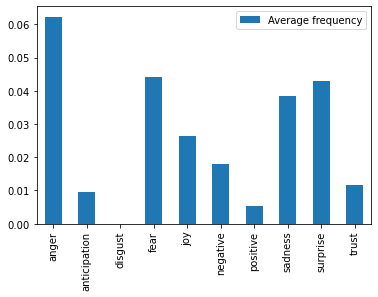

In [404]:
df_mean = pd.DataFrame(df[column].mean())
df_mean.columns = ['Average frequency']
ax = df_mean.plot.bar(stacked=True)

# Stock returns

# A faire pour cette méthode : 
- classer les earning calls par quarter et par stock index
- importer les stock returns et garder seulement ceux des earning calls (mapping permno/ stock index)

# liens utiles

https://betterprogramming.pub/unlocking-emotions-in-text-using-python-6d062b48d71f